In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import _pickle as pickle
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

from tqdm.notebook import tqdm

from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel, RobertaTokenizer, TFRobertaModel, TFRobertaMainLayer
import tensorflow as tf

def equal(a, b):
#     assert len(a) == len(b)
    val = True
    for i in range(len(a)):
        if a[i] != b[i]:
            val = False
    return val

import difflib

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_length = 64

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
max_length = 64

In [ ]:
df_train = pd.read_csv('train.csv')

In [ ]:
df_train.head()

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
line = df_train.iloc[14]
s1 = ' '.join(line['sentiment'].split())
s2 = ' '.join(line['text'].split())
s3 = ' '.join(line['selected_text'].split())

In [ ]:
print(s1)
print(s2)
print(s3)

In [ ]:
def extract(s1,s2,s3, max_length):
    encoded = tokenizer.encode_plus(s1, s2, add_special_tokens = True, max_length = max_length, pad_to_max_length = True)
    encoded_answer1 = tokenizer.encode_plus('</s> ' + s3, add_special_tokens = False)
    encoded_answer2 = tokenizer.encode_plus('start ' + s3, add_special_tokens = False)

    input_id = np.array(encoded['input_ids'])
    input_masks = np.array(encoded['attention_mask'])
    input_types = np.array(encoded['token_type_ids'])

    answer1 = np.array(encoded_answer1['input_ids'][1:])
    answer2 = np.array(encoded_answer2['input_ids'][1:])

    ## End and Start token
    start = np.zeros(len(input_id))
    end = np.zeros(len(input_id))
    valid = np.zeros(len(input_id))
    
    found = False
    for i in range(len(input_id) - len(answer1)):
        if equal(input_id[i: i + len(answer1)],answer1):
            st = i
            en = i + len(answer1) -1
#             print(input_id[st: en +1])
#             print(tokenizer.decode(input_id[st: en+1]))
            found = True

        elif equal(input_id[i: i + len(answer2)],answer2):
            st = i
            en = i + len(answer2) -1
#             print(input_id[st: en +1])
#             print(tokenizer.decode(input_id[st: en+1]))
            found = True
    if found == False:
        print('no answer found')
    else:
        start[st] = 1
        end[en] = 1
        valid[st:en+1] = 1
        
    for i in range(len(input_masks)):
        if input_masks[i] == 0:
            start[i] = 2
            end[i] = 2
            valid[i] = 2
            
    ## token ids
    input_types[3:] = 1

    for elt in range(len(input_masks)):
        if input_masks[elt] == 0:
            input_types[elt] = 0
            
    return input_id, input_masks, input_types, start, end, valid, found*1

In [ ]:
input_id, input_masks, input_types, start, end, valid, found = extract(s1,s2,s3,128)

In [ ]:
start

In [ ]:
end

In [ ]:
valid

In [ ]:
X = []
X_type = []
X_masks = []

token_start = []
token_end = []
token = []

X_text = []
Y_text = []

found_count = 0
max_length = 64
for index, line in tqdm(df_train.iterrows(), total = df_train.shape[0]):
    s1 = ' '.join(line['sentiment'].split())
    s2 = ' '.join(str(line['text']).split())
    s3 = ' '.join(str(line['selected_text']).split())
    
    input_id, input_masks, input_types, start, end, valid, found = extract(s1,s2,s3, max_length)
    
    found_count += found
    
    X.append(input_id)
    X_type.append(input_types)
    X_masks.append(input_masks)
    
    token_start.append(start)
    token_end.append(end)
    token.append(valid)
    
    X_text.append(s2)
    Y_text.append(line['selected_text'])

In [ ]:
found_count

In [ ]:
len(X_text)

In [ ]:
df_train.shape

In [ ]:
ind = 5
a = X[ind]

ts = token_start[ind]
te = token_end[ind]
ts = ts[ts !=2]
te = te[te !=2]
print(a)
# print(Y[ind])
print(tokenizer.decode(a))
print(tokenizer.decode(a[np.argmax(ts):np.argmax(te)+1]))
print(Y_text[ind])
print(X_type[ind])
print(X_masks[ind])
print(token_start[ind])

In [ ]:
save((X, X_type, X_masks, X_text, Y_text, token_start, token_end, token), 'train_set')

## Preparing dataset

In [2]:
(X, X_type, X_masks, X_text, Y_text, token_start, token_end, token) = load('train_set')

In [3]:
from keras.utils import np_utils
X = np.array(X)
X_type = np.array(X_type)
X_masks = np.array(X_masks)

token_start = np.array(token_start)
token_end = np.array(token_end)
token = np.array(token)

both = np.concatenate([token_start.reshape(token_start.shape[0], token_start.shape[1], 1), token_end.reshape(token_end.shape[0], token_end.shape[1], 1)], axis = -1)
both[both == 2] = 0
token_start[token_start == 2] = 0
# token_end[token_end == 2] = 0
# token[token == 2] = 0

Using TensorFlow backend.


In [4]:
def count(token):
    a = []
    for elt in token:
        c = 0
        for i in elt:
            if i == 1:
                c+=1
        a.append(c)
    return np.array(a)

In [5]:
from sklearn.model_selection import train_test_split
X_train_ids, X_test_ids, y_train_start, y_test_start = train_test_split(X, token_start, random_state=42, test_size=0.1)
X_train_mask, X_test_mask, Y_text_train, Y_text_test = train_test_split(X_masks, Y_text, random_state=42, test_size=0.1)
X_train_type, X_test_type, X_text_train, X_text_test = train_test_split(X_type, X_text, random_state=42, test_size=0.1)
y_train_end, y_test_end, token_train, token_test = train_test_split(token_end, token, random_state=42, test_size=0.1)

X_train = [X_train_ids, X_train_mask, X_train_type]
X_test = [X_test_ids, X_test_mask, X_test_type]

# y_train = [y_train_start, y_train_end]
# y_test = [y_test_start, y_test_end]

y_train = [token_train, count(token_train)]
y_test = [token_test, count(token_test)]



In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, Embedding, Concatenate

max_length = 64

inputs_ids = Input(shape = (max_length,), dtype = 'int32')
inputs_mask = Input(shape = (max_length,), dtype = 'int32')
inputs_type = Input(shape = (max_length,), dtype = 'float32')

inputs = [inputs_ids, inputs_mask, inputs_type]

# sentence_encoder = TFBertModel.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.  
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

sentence_encoder = TFRobertaModel.from_pretrained('roberta-base',
                                               output_attentions = False,
                                               output_hidden_states = False,
                                               )
sentence_encoder.config.type_vocab_size = 2 
sentence_encoder.roberta.embeddings.token_type_embeddings = Embedding(2, sentence_encoder.config.hidden_size)

sentence_encoder.load_weights('./checkpoints/roberta_layer_epoch_'+str(0)+'_batch_'+str(14)+'/checkpoint.h5py')

encoded = sentence_encoder(inputs_ids, attention_mask = inputs_mask, token_type_ids = inputs_type)
pooled_encoded = encoded[0]
pooled_encoded_1 = encoded[1]
drop = Dropout(0.3)(pooled_encoded)

out1 = TimeDistributed(Dense(1, activation = 'sigmoid'))(drop)
out2 = Dense(1, activation = 'relu')(pooled_encoded_1)
# out2 = TimeDistributed(Dense(1, activation = 'sigmoid'))(drop)

# out1 = Dense(1, activation = 'sigmoid')(drop)
# out2 = Dense(1, activation = 'sigmoid')(drop)

out = [out1, out2]
# out = Concatenate(axis = -1)([out1, out2])
# out = TimeDistributed(Dense(2, activation = 'sigmoid'))(drop)

model = Model(inputs, out)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 64, 768), (N 124646400   input_1[0][0]                    
______________________________________________________________________________________________

In [8]:
def masked_cross_entropy(real, pred):
    
    real = tf.cast(real, dtype = pred.dtype)
    
    mask = tf.math.logical_not(tf.math.equal(real, 2))
    mask = tf.cast(mask, dtype = real.dtype)
    
    loss = (real*tf.math.log(pred) + (1-real)*tf.math.log(1-pred))*mask
#     print(loss)
    loss = - tf.reduce_mean(loss)
    
    return loss

def inter_len(real, pred):
    
    real = tf.cast(real, dtype = pred.dtype)
    
    mask = tf.math.logical_not(tf.math.equal(real, 2))
    mask = tf.cast(mask, dtype = real.dtype)
    
    real = real*mask
    pred = pred*mask
#     print(real)
#     print(pred)
    categorical_pred = tf.cast(tf.math.greater(pred, 0.5), dtype = pred.dtype)
    
    inter = tf.reduce_sum(real*categorical_pred)
    p = tf.reduce_sum(categorical_pred)
    r = tf.reduce_sum(real)
#     print(inter)
#     print(p)
#     print(r)
    
    loss = inter/(p+r-inter)
    
    return 1-loss

def custom_loss(real, pred, ratio = 0.5):
    
    loss1 = masked_cross_entropy(real, pred)
    loss2 = inter_len(real, pred)
    
    loss = ratio*loss1 + (1-ratio)*loss2
    
    return loss*100

def jaccard_metric(real, pred):
    real = tf.cast(real, dtype = pred.dtype)
    
    mask = tf.math.logical_not(tf.math.equal(real, 2))
    mask = tf.cast(mask, dtype = real.dtype)
    
    real = real*mask
    pred = pred*mask
    
    categorical_pred = tf.cast(tf.math.greater(pred, 0.5), dtype = pred.dtype)
    
    inter = tf.reduce_sum(real*categorical_pred)
    p = tf.reduce_sum(categorical_pred)
    r = tf.reduce_sum(real)
    metric = inter/(p+r-inter)
    return metric

def acc(real, pred):
    real = tf.cast(real, dtype = pred.dtype)
    
    mask = tf.math.logical_not(tf.math.equal(real, 2))
    mask = tf.cast(mask, dtype = real.dtype)
    
    categorical_pred = tf.cast(tf.math.greater(pred, 0.5), dtype = pred.dtype)
    
    is_equal = tf.cast(real==categorical_pred, real.dtype)
    
    n_true = tf.math.reduce_sum(is_equal * mask)
    
    return n_true / tf.math.reduce_sum(mask)
    
# def custom_loss(true, pred):
    
#     true = tf.cast(true, dtype = pred.dtype)
#     st_true = true[:, 0]
#     en_true = true[:, 1]
    
#     st_pred = pred[:, 0]
#     en_pred = pred[:, 1]
    
#     mask = tf.math.logical_not(tf.math.equal(st_true, 2))
#     mask = tf.cast(mask, dtype = st_true.dtype)
    
#     ## Categorical crossentropy
#     loss_start = masked_cross_entropy(st_true, st_pred)
#     loss_en = masked_cross_entropy(en_true, en_pred)
    
    
#     ## Jaccard
#     st_true = st_true*mask
#     en_true = en_true*mask
    
#     st_pred = st_pred*mask
#     en_pred = en_pred*mask
    
#     stt = tf.math.argmax(st_true)
#     ent = tf.math.argmax(en_true)
    
#     stp = tf.math.argmax(st_pred)
#     enp = tf.math.argmax(en_pred)
    
#     lp = tf.math.maximum(enp - stp + 1 , 0)
#     lt = tf.math.maximum(ent - stt + 1, 0)
    
# #     int1 = tf.math.maximum(ent - stp + 1, 0)
# #     int2 = tf.math.maximum(enp - stt + 1, 0)
#     int_abs = tf.math.minimum(ent - stp + 1, enp - stt + 1)
#     int_abs = tf.math.maximum(int_abs, 0)
    
#     jac = int_abs / ( lp+ lt - int_abs)
    
# #     return loss_start, loss_en, jac
#     return 0.5 * loss_start + 0.5 * loss_en# + 0.2 * (1-jac)
    
# def acc_start(true, pred):
#     true = tf.cast(true, dtype = pred.dtype)
#     st_true = true[:, 0]
#     st_pred = pred[:, 0]
    
#     mask = tf.math.logical_not(tf.math.equal(st_true, 2))
#     mask = tf.cast(mask, dtype = st_true.dtype)
    
#     st_true = st_true * mask
#     st_pred = st_pred * mask
    
#     r= tf.math.argmax(st_true)
#     p = tf.math.argmax(st_pred)
  
#     return tf.cast(p==r, true.dtype)

# def acc_end(true, pred):
#     true = tf.cast(true, dtype = pred.dtype)
#     en_true = true[:, 1]
#     en_pred = pred[:, 1]
    
#     mask = tf.math.logical_not(tf.math.equal(en_true, 2))
#     mask = tf.cast(mask, dtype = en_true.dtype)
    
#     en_true = en_true * mask
#     en_pred = en_pred * mask
    
#     r= tf.math.argmax(en_true)
#     p = tf.math.argmax(en_pred)
  
#     return tf.cast(p==r, true.dtype)

# def acc(true, pred):
#     true = tf.cast(true, dtype = pred.dtype)
#     mask = tf.math.logical_not(tf.math.equal(true, 2))
#     mask = tf.cast(mask, dtype = true.dtype)
    
#     r= tf.math.argmax(true)
#     p= tf.math.argmax(pred)
#     return tf.cast(p==r, true.dtype)
    
    
# def jaccard_metric(true, pred):
#     true = tf.cast(true, dtype = pred.dtype)
#     st_true = true[:, 0]
#     en_true = true[:, 1]
    
#     st_pred = pred[:, 0]
#     en_pred = pred[:, 1]
    
#     mask = tf.math.logical_not(tf.math.equal(st_true, 2))
#     mask = tf.cast(mask, dtype = st_true.dtype)
    
#     ## Jaccard
#     st_true = st_true*mask
#     en_true = en_true*mask
    
#     st_pred = st_pred*mask
#     en_pred = en_pred*mask
    
#     stt = tf.math.argmax(st_true)
#     ent = tf.math.argmax(en_true)
    
#     stp = tf.math.argmax(st_pred)
#     enp = tf.math.argmax(en_pred)
    
#     lp = tf.math.maximum(enp - stp + 1 , 0)
#     lt = tf.math.maximum(ent - stt + 1, 0)
    
# #     int1 = tf.math.maximum(ent - stp + 1, 0)
# #     int2 = tf.math.maximum(enp - stt + 1, 0)
#     int_abs = tf.math.minimum(ent - stp + 1, enp - stt + 1)
#     int_abs = tf.math.maximum(int_abs, 0)
    
#     jac = int_abs / ( lp+ lt - int_abs)
    
#     return jac

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam, SGD

loss_classif     =  'categorical_crossentropy'# find the right loss for multi-class classification
optimizer        =  Adam(3e-5, 1e-8) # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=[custom_loss, 'mse'],
              optimizer=optimizer,
              metrics=[jaccard_metric, acc])

early = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, 
                                                mode='auto', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

bs = 32
n_epochs = 2
#, batch_size=bs
history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_test,  y_test), callbacks = [early, reduce])

Train on 24732 samples, validate on 2749 samples
Epoch 1/3
24732/24732 [==============================] - 277s 11ms/sample - loss: 54.9064 - time_distributed_loss: 22.8112 - dense_1_loss: 32.0903 - time_distributed_jaccard_metric: 0.6714 - time_distributed_acc: 0.8538 - dense_1_jaccard_metric: 9.9376 - dense_1_acc: 0.1710 - val_loss: 45.1709 - val_time_distributed_loss: 18.9938 - val_dense_1_loss: 26.1555 - val_time_distributed_jaccard_metric: 0.7240 - val_time_distributed_acc: 0.8814 - val_dense_1_jaccard_metric: 10.1287 - val_dense_1_acc: 0.1798
Epoch 2/3
24732/24732 [==============================] - 264s 11ms/sample - loss: 46.8688 - time_distributed_loss: 20.2064 - dense_1_loss: 26.6588 - time_distributed_jaccard_metric: 0.7075 - time_distributed_acc: 0.8742 - dense_1_jaccard_metric: 9.9658 - dense_1_acc: 0.1716 - val_loss: 45.2753 - val_time_distributed_loss: 18.9997 - val_dense_1_loss: 26.2536 - val_time_distributed_jaccard_metric: 0.7223 - val_time_distributed_acc: 0.8824 - val

KeyboardInterrupt: 

In [10]:
loss_classif     =  'categorical_crossentropy'# find the right loss for multi-class classification
optimizer        =  Adam(3e-6, 1e-8) # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=[custom_loss, 'mse'],
              optimizer=optimizer,
              metrics=[jaccard_metric, acc])

early = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, 
                                                mode='auto', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

bs = 32
n_epochs = 1
#, batch_size=bs
history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_test,  y_test), callbacks = [early, reduce])

Train on 24732 samples, validate on 2749 samples
24732/24732 [==============================] - 281s 11ms/sample - loss: 41.9101 - time_distributed_loss: 19.1629 - dense_1_loss: 22.7548 - time_distributed_jaccard_metric: 0.7219 - time_distributed_acc: 0.8792 - dense_1_jaccard_metric: 9.9706 - dense_1_acc: 0.1716 - val_loss: 42.9139 - val_time_distributed_loss: 18.7169 - val_dense_1_loss: 24.1762 - val_time_distributed_jaccard_metric: 0.7317 - val_time_distributed_acc: 0.8823 - val_dense_1_jaccard_metric: 10.1287 - val_dense_1_acc: 0.1798


In [12]:
pred = model.predict(X_test)
# pred = pred.reshape(pred.shape[0], pred.shape[1])

pred = [pred[0].reshape(pred[0].shape[0], pred[0].shape[1]), pred[1].reshape(pred[1].shape[0])]

# pred[0] = pred[0].reshape(pred[0].shape[0], pred[0].shape[1])
# pred[1] = pred[1].reshape(pred[1].shape[0], pred[1].shape[1])

# pred = [0,0]
# pred[0] = pred1[:,:,0]
# pred[1] = pred1[:,:,1]

wee. done with advance audit paper
wee. done with advance audit paper


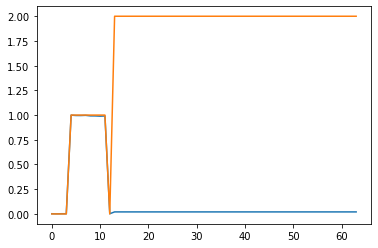

In [21]:
ind = 9


plt.plot(pred[0][ind])
plt.plot(y_test[0][ind])
# plt.figure(0)
# plt.plot(pred[0][ind])
# plt.plot(y_test[0][ind])
# # plt.plot(y_test[ind][:,0])
# plt.figure(2)
# plt.plot(pred[1][ind])
# plt.plot(y_test[1][ind])
# # plt.plot(y_test[ind][:,1])

print(Y_text_test[ind])
# st = np.argmax(pred[0][ind])
# en = np.argmax(pred[1][ind][st:]) + st
# vect = X_test[0][ind, st:en+1]

# vect = X_test[0][ind, pred[ind] >= 0.5]
# vect = vect[vect != 1]

vect = X_test[0][ind]

p = pred[0][ind]
n_token = int(pred[1][ind])+1

p = p[vect != 1]
p = np.argsort(p)[-n_token:]
p = np.sort(p)
vect = vect[p]
vect = vect[vect != 1]

vect = tokenizer.decode(vect)
print(vect)

In [22]:
def inference(pred, X, X_text, x):
    prediction = []
    for i, elt in tqdm(enumerate(X[0]), total = len(X[0])):
        
#         st = np.argmax(pred[0][i])
#         en = np.argmax(pred[1][i][st:]) + st
        
#         print(st)
        
#         vect = X_test[0][i, pred[i] >= x]
#         vect = vect[vect != 1]
#         vect = tokenizer.decode(vect)
        
#         vect = X[0][i, st:en+1]
#         vect = tokenizer.decode(vect)
        
        # get closest inference
        
        vect = X_test[0][ind]

        p = pred[0][ind]
        n_token = int(pred[1][ind])+1

        p = p[vect != 1]
        p = np.argsort(p)[-n_token:]
        p = np.sort(p)
        vect = vect[p]
        vect = vect[vect != 1]
        
         
        vect = tokenizer.decode(vect)
        
        vect = vect.split()
        true = X_text[i].lower().split()
        vect1 = []
        for elt in vect:
            inf = difflib.get_close_matches(elt, true)
            if len(inf) == 0:
                vect1.append(elt)
            else:
                vect1.append(inf[0])
        vect1 = ' '.join(vect1)
        
        prediction.append(vect1)
#         prediction.append(' '.join(vect))
    
    return prediction

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def evaluate(prediction, true):
    value = []
    for i in range(len(prediction)):
        str1 = true[i]
        str2 = prediction[i]
        
        value.append(jaccard(str1, str2))
    score = np.mean(value)
    
    return value, score

import optuna
def objective(trial):
    x = trial.suggest_uniform('x', 0, 1)
    
    prediction = inference(pred, X_test, X_text_test, x)
    value,j = evaluate(prediction, Y_text_test)
    print(j)
    
    return 1-j

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)

In [ ]:
x = study.best_params['x']

In [23]:
x = 0

In [24]:
prediction = inference(pred, X_test, X_text_test, x)

In [25]:
value, score = evaluate(prediction, Y_text_test)

In [26]:
score

0.023119052436251425

(array([2.541e+03, 1.920e+02, 1.500e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

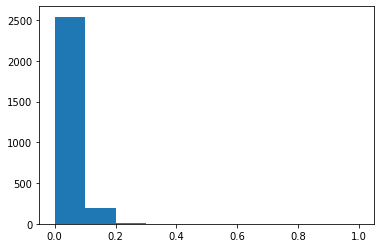

In [27]:
plt.hist(value)